In [1]:
import transformers

In [1]:
import numpy as np


In [2]:
import pandas as pd

Loading & Preprocessing Dataset

In [ ]:
df=pd.read_csv("reviews.csv")

In [ ]:
#Checking Null values
df.isnull().sum()

,0
reviewId,0
userName,0
userImage,0
content,0
score,0
thumbsUpCount,0
reviewCreatedVersion,2162
at,0
replyContent,6677
repliedAt,6677


In [5]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo


In [ ]:
df.describe()

,score,thumbsUpCount
count,12495.000000,12495.000000
mean,3.094198,3.047459
std,1.457693,14.303903
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,4.000000,1.000000
max,5.000000,397.000000


In [ ]:
#Keeping only scopre and content column for sentiment analyis
df=df[['score','content']]

In [8]:
df.head()

,score,content
0,1,I cannot open the app anymore
1,1,I have been begging for a refund from this app...
2,1,Very costly for the premium version (approx In...
3,1,"Used to keep me organized, but all the 2020 UP..."
4,1,Dan Birthday Oct 28


In [9]:
df.isnull().sum()

,0
score,0
content,0


In [ ]:
# Maping numeric score to sentiment categories
def map_sentiment(score):
    if score >= 4:
        return "positive"
    elif score == 3:
        return "neutral"
    else:
        return "negative"

df['sentiment'] = df['score'].apply(map_sentiment)
df = df[['content', 'sentiment']].dropna()

df['sentiment'].value_counts()

,count
sentiment,
positive,5654
negative,4850
neutral,1991


/tmp/ipython-input-11-759891224.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Set2')


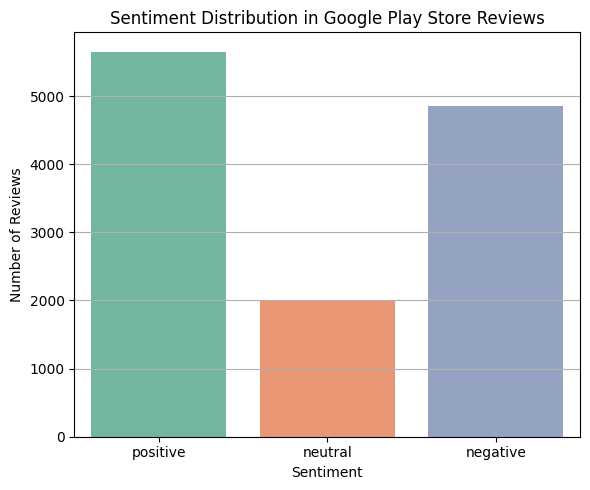

In [ ]:
#Plotting review sentiment distrbution in bar plot
import matplotlib.pyplot as plt
import seaborn as sns

sentiment_counts = df['sentiment'].value_counts().reindex(['positive', 'neutral', 'negative'])

# Plot
plt.figure(figsize=(6,5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Set2')
plt.title("Sentiment Distribution in Google Play Store Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [12]:
df.head()

,content,sentiment
0,I cannot open the app anymore,negative
1,I have been begging for a refund from this app...,negative
2,Very costly for the premium version (approx In...,negative
3,"Used to keep me organized, but all the 2020 UP...",negative
4,Dan Birthday Oct 28,negative


Encodeing Labels and Load as HuggingFace Dataset

In [ ]:
from datasets import Dataset, ClassLabel

# Converting to HuggingFace Dataset
dataset = Dataset.from_pandas(df)

# Encoding the sentiment column as class labels
label_classes = ClassLabel(names=["negative", "neutral", "positive"])
dataset = dataset.class_encode_column("sentiment")

# Train-test split
dataset = dataset.train_test_split(test_size=0.2)

Casting to class labels:   0%|          | 0/12495 [00:00<?, ? examples/s]

 Tokenizing the Dataset Using BERT Tokenizer

In [ ]:
from transformers import AutoTokenizer

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize function
def tokenize_function(example):
    return tokenizer(example["content"], padding="max_length", truncation=True)

dataset = dataset.rename_column("sentiment", "labels")

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/9996 [00:00<?, ? examples/s]

Map:   0%|          | 0/2499 [00:00<?, ? examples/s]

 Fine-Tune the BERT Model

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Loading pre-trained BERT for classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=3
)

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=10,  
    logging_strategy="steps",
    report_to="none",  

)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train
trainer.train()

/tmp/ipython-input-20-2276608951.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.642300,0.687069,0.739759,0.685206,0.638670,0.739759
2,0.573700,0.669776,0.756627,0.725219,0.716724,0.756627
3,0.476000,0.697218,0.749398,0.734896,0.727825,0.749398
4,0.310500,0.715717,0.756627,0.734348,0.719694,0.756627
5,0.271600,0.736080,0.749398,0.728890,0.715674,0.749398


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=520, training_loss=0.5052266914110918, metrics={'train_runtime': 978.267, 'train_samples_per_second': 8.464, 'train_steps_per_second': 0.532, 'total_flos': 2178579098787840.0, 'train_loss': 0.5052266914110918, 'epoch': 5.0})

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

NameError: name 'eval_results' is not defined

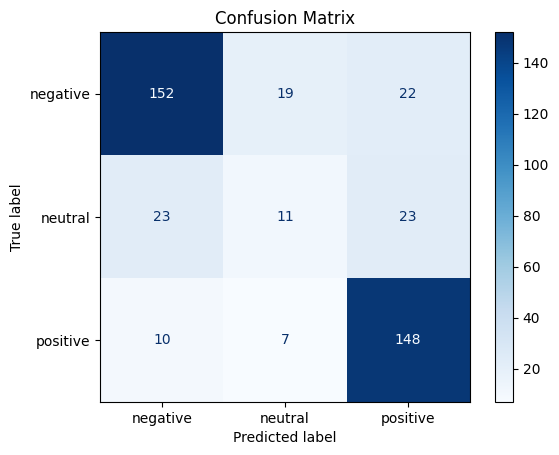

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Get predictions
preds_output = trainer.predict(tokenized_dataset["test"])
y_true = preds_output.label_ids
y_pred = preds_output.predictions.argmax(axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_classes.names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [23]:
trainer.save_model("bert-sentiment-model")
tokenizer.save_pretrained("bert-sentiment-model")

('bert-sentiment-model/tokenizer_config.json',
 'bert-sentiment-model/special_tokens_map.json',
 'bert-sentiment-model/vocab.txt',
 'bert-sentiment-model/added_tokens.json',
 'bert-sentiment-model/tokenizer.json')

In [ ]:
import matplotlib.pyplot as plt


epochs = [1, 2, 3, 4, 5]
train_loss = [0.6423, 0.5737, 0.4760, 0.3105, 0.2716]
val_loss   = [0.6871, 0.6698, 0.6972, 0.7157, 0.7361]
accuracy   = [0.7398, 0.7566, 0.7494, 0.7566, 0.7494]
f1_score   = [0.6852, 0.7252, 0.7349, 0.7343, 0.7289]
precision  = [0.6387, 0.7167, 0.7278, 0.7197, 0.7157]
recall     = [0.7398, 0.7566, 0.7494, 0.7566, 0.7494]

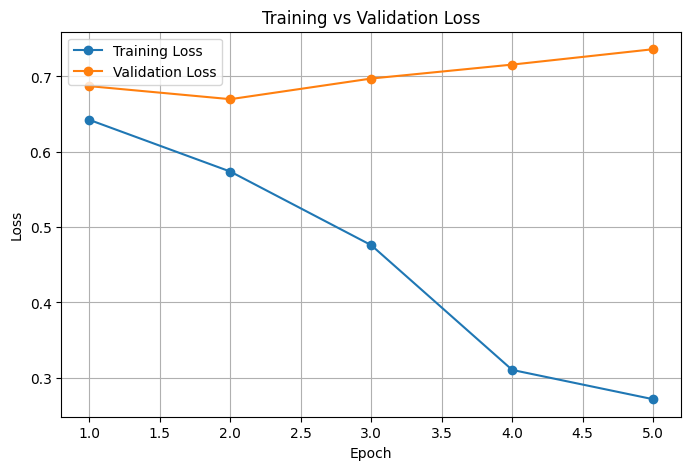

In [25]:
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label="Training Loss", marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


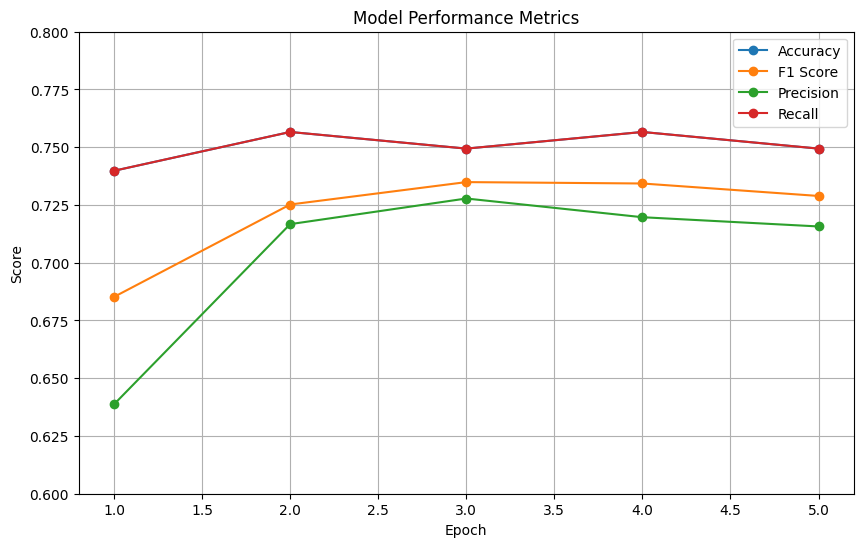

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(epochs, accuracy, label="Accuracy", marker='o')
plt.plot(epochs, f1_score, label="F1 Score", marker='o')
plt.plot(epochs, precision, label="Precision", marker='o')
plt.plot(epochs, recall, label="Recall", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Model Performance Metrics")
plt.legend()
plt.grid(True)
plt.ylim(0.6, 0.8)  


In [30]:
import torch

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_class_id = outputs.logits.argmax().item()
    return label_classes.int2str(predicted_class_id)

Predicting the sentiment for unseen data

In [33]:
sample_reviews = [
    "This app is amazing and easy to use!",
    "I paid for premium but it doesn't work properly.",
    "The new update is fine, but I preferred the old version.",
    "App crashes every time I try to open it.",
    "Simple, intuitive, and gets the job done.",
    "Too many ads and notifications, very annoying.",
    "It's okay, not the best but not the worst.",
    "Love the UI and features. Great job team!",
    "Still waiting for bug fixes. Not impressed.",
    "Does exactly what I need it to. Satisfied!"
]
actual_labels = [
    "positive",
    "negative",
    "neutral",
    "negative",
    "positive",
    "negative",
    "neutral",
    "positive",
    "negative",
    "positive"
]

# Create prediction results with actual sentiment
results = [(review, actual, predict_sentiment(review))
           for review, actual in zip(sample_reviews, actual_labels)]

df_preds = pd.DataFrame(results, columns=["Review", "Actual Sentiment", "Predicted Sentiment"])
df_preds

,Review,Actual Sentiment,Predicted Sentiment
0,This app is amazing and easy to use!,positive,positive
1,I paid for premium but it doesn't work properly.,negative,negative
2,"The new update is fine, but I preferred the ol...",neutral,neutral
3,App crashes every time I try to open it.,negative,negative
4,"Simple, intuitive, and gets the job done.",positive,positive
5,"Too many ads and notifications, very annoying.",negative,negative
6,"It's okay, not the best but not the worst.",neutral,neutral
7,Love the UI and features. Great job team!,positive,positive
8,Still waiting for bug fixes. Not impressed.,negative,negative
9,Does exactly what I need it to. Satisfied!,positive,positive
